# KNN分类任务-wine数据集
09118241 陈嘉源

In [1]:
import numpy as np
import pandas as pd
import math
import csv
import matplotlib.pyplot as plt
import scipy
from scipy import io

train_path = './data/train_data.mat'#125-训练集
val_path = './data/val_data.mat'#27-验证集
test_path = './data/test_data.mat'#26-测试集
result_path1 = './task1_test_prediction.csv'
result_path2 = './task2_test_prediction.csv'

## 定义工具函数：加载数据、数据预处理（归一化、缺失值补充）、欧式距离、计算准确率

In [2]:
def dataloader(path):
    data_a = scipy.io.loadmat(path)
    data_b = list(data_a.values())
    data = np.array(data_b[3]) #n*13
    label = np.array(data_b[4]) #n*1
    return data,label

def normalization(input_data):
    '''
    数据预处理 归一化，‘nan‘用均值代替
    '''
    nan = input_data[:,12]
    list_para = []
    for k in range(len(nan)):
        if nan[k] > 0:
            list_para.append(nan[k])
    mean_para = np.mean(list_para)
    for k in range(len(input_data[:,12])):
        if np.isnan(input_data[k][12]):
            input_data[k][12]=mean_para
    for i in range(13):
        data = input_data[:,i]
        mean = np.mean(data)
        maxi = data.max()
        mini = data.min()
        for j in range(len(data)):
            input_data[j][i] = (data[j]-mini)/(maxi-mini)

def distance(x,y):
    dim = len(x)
    sum_dis = 0
    for i in range(dim):
        sum_dis+=(x[i]-y[i])**2
    return math.sqrt(sum_dis)

def test(train,val):
    '''
    测试knn中参数k
    '''
    accuracy_list = []
    for k in range(9):
        train_list = []
        for i in val:
            a = KnnClassifier(k+1,train,train_label,i)
            train_list.append(a)
        tmp = accuracy(train_list,val_label)
        accuracy_list.append(tmp)
    return accuracy_list
            
def accuracy(label,test_label):
    '''
    计算准确率
    '''
    k=0
    for i in range(len(label)):
        if label[i] == test_label[i]:
            k+=1
    return k/(len(label))            

In [3]:
train_data,train_label = dataloader(train_path) #125*13 ，125*1
val_data,val_label = dataloader(val_path)       #27*13，27*1
test_data = np.array(list(scipy.io.loadmat(test_path).values())[3]) #26*13
#数据预处理
normalization(train_data)
normalization(val_data)
normalization(test_data)

## KNN分类器:（参数k,数据集,标签,待分类数据）

In [4]:
def KnnClassifier(k,dataset,labelset,input_y):
    '''
    k：参数 
    dataset：数据集 
    labelset：标签
    input_y：待分类样本
    '''
    n = len(dataset)
    dis = []
    label_list =[]
    
    for i in range(n):
        dis_i=distance(dataset[i],input_y)
        dis.append(dis_i)
    
    dis_k = sorted(dis)[:k] #距离升序排序
    #print(dis_k)
    for j in range(k):
        tmp = dis.index(dis_k[j])
        label_list.append(labelset[tmp])
    label = max(label_list, key=label_list.count)
    #print(label)
    return label

## 马氏距离，学习线性映射

In [5]:
class Mahalanobis_Distance():
    def __init__(self, low_dims, learning_rate = 0.01, max_steps = 500):
        '''
        low_dims : 线性映射后的维度
        learning_rate :梯度下降的学习率 default 0.01
        max_steps : 梯度下降停止步长 default 500
        '''
        self.low_dims = low_dims
        self.learning_rate = learning_rate
        self.max_steps = max_steps

    def fit(self, X, Y):
        '''
        学习映射矩阵 A
        maximize \sum_i \sum_{j \in C_i} frac{exp(-||Ax_i-Ax_j||^2)}{\sum_{k neq i} exp(-||Ax_i-Ax_k||^2)}
        '''
        (n, d) = X.shape 
        self.n_samples = n#125
        self.high_dims = d#13

        # matrix A
        self.A = 0.1 * np.random.standard_normal(size = (self.high_dims, self.low_dims))

        # 梯度下降
        steps = 0
        target = 0.0
        while steps < self.max_steps:
            low_X = np.dot(X, self.A)                      #125*2
            sum_row = np.sum(low_X ** 2, axis = 1)
            xxt = np.dot(low_X, low_X.transpose())
            pij_mat = sum_row + np.reshape(sum_row, (-1, 1)) - 2 * xxt       # (125, 125)
            pij_mat = np.exp(0.0 - pij_mat)
            np.fill_diagonal(pij_mat, 0.0)
            pij_mat = pij_mat / np.sum(pij_mat, axis = 1)[:, None]          # (125, 125)
            #mask_{ij} = True if Y[i] == Y[j]  
            mask = (Y == Y[:, None])    
            mask = np.resize(mask, (125,125)) 
            # mask array
            pij_mat_mask = pij_mat * mask                                        # (125, 125)
            # pi = \sum_{j \in C_i} p_{ij}
            pi_arr = np.array(np.sum(pij_mat_mask, axis = 1))                    # (125, )
            self.target = np.sum(pi_arr)
            # 梯度
            weighted_pij = pij_mat_mask - pij_mat * pi_arr[:, None]             # (125, 125)
            weighted_pij_sum = weighted_pij + weighted_pij.transpose()          # (125, 125)
            np.fill_diagonal(weighted_pij_sum, -weighted_pij.sum(axis = 0))
            tmp = (low_X.transpose().dot(weighted_pij_sum))                         #2*125 125*125 = 2*125
            gradients = 2 * np.dot(tmp,X).transpose()                               # (13, 2)
            # 更新A
            self.A += 0.01 * gradients
            # step++
            steps += 1

    def transform(self, X):
        '''
        特征线性映射
        '''
        low_X = np.dot(X, self.A)
        return low_X
    
    def get_A(self):
        #print(self.A)
        return self.A


## 在训练集上学习，并进行线性映射

In [6]:
mahalanobis = Mahalanobis_Distance(low_dims = 2, max_steps = 100)
mahalanobis.fit(train_data, train_label)
low_train = mahalanobis.transform(train_data)
low_val = mahalanobis.transform(val_data)

## 分别对欧式距离和马氏距离两种度量测试准确率，并分析参数k的影响

In [7]:
oushi = test(train_data,val_data)
mashi = test(low_train,low_val)
print('Euclidean Distance:')
for i in range(len(oushi)):
    print('k=',i+1, 'accuracy=',oushi[i])
print('Mahalanobis Distance:')
for i in range(len(mashi)):
    print('k=',i+1, 'accuracy=',mashi[i])

Euclidean Distance:
k= 1 accuracy= 0.8888888888888888
k= 2 accuracy= 0.8888888888888888
k= 3 accuracy= 0.8888888888888888
k= 4 accuracy= 0.8888888888888888
k= 5 accuracy= 0.9259259259259259
k= 6 accuracy= 0.9259259259259259
k= 7 accuracy= 0.9259259259259259
k= 8 accuracy= 0.9259259259259259
k= 9 accuracy= 0.9259259259259259
Mahalanobis Distance:
k= 1 accuracy= 0.9629629629629629
k= 2 accuracy= 0.9629629629629629
k= 3 accuracy= 0.9259259259259259
k= 4 accuracy= 0.9629629629629629
k= 5 accuracy= 0.9629629629629629
k= 6 accuracy= 0.9629629629629629
k= 7 accuracy= 0.9629629629629629
k= 8 accuracy= 0.9629629629629629
k= 9 accuracy= 0.9629629629629629


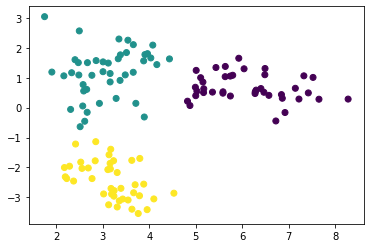

In [8]:
#马氏距离降维结果可视化
plt.scatter(low_train[:, 0], low_train[:, 1], c = train_label[:,0])
plt.show()  

## 在测试集上预测标签，写入csv

In [9]:
f = open(result_path1,'w',encoding='utf-8')
csv_writer = csv.writer(f)
for i in test_data:
    csv_writer.writerow(KnnClassifier(9,train_data,train_label,i))
print('finishied')
f.close()

finishied


In [10]:
test_ma = mahalanobis.transform(test_data)
f = open(result_path2,'w',encoding='utf-8')
csv_writer = csv.writer(f)
for i in test_ma:
    csv_writer.writerow(KnnClassifier(9,low_train,train_label,i))
print('finishied')
f.close()

finishied
